# Lab 5: Species Distribution Modeling with Bagging 
Climate change and deforestation are accelerating ecosystem degradation, pushing animal species toward the brink of extinction. Understanding the distribution of animals and the factors that influence their ability to thrive in different environments is critical for conservation efforts. By studying these relationships, biological conservationists can develop informed strategies to protect endangered species and maintain biodiversity across diverse ecosystems.

Species are defined by their behavioral, physiological, and ecological attributes, which shape their roles in ecosystems. In turn, ecosystems and their functions are deeply influenced by the species that inhabit them. This reciprocal relationship makes evaluating species' functional diversity and distributions essential for research in biogeography, community ecology, macroevolution, and conservation. Functional diversity is determined by traits such as diet, foraging strata, trophic level, activity cycle, litter size, generation length, habitat breadth, and body mass. These traits influence an animal’s ability to survive and adapt to different climates, playing a crucial role in ecosystem stability.

In this lab, we will explore the connections between animal behaviors, functional traits, and species distributions across different climates.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc,roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.utils import resample, shuffle
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer

# Expand dataframe columns and look at view dataframe
pd.set_option('display.max_columns', None)

### Step 1: Standardizing column names

The dataset contains several columns that describe different aspects of bird diets. These column names currently include spaces, colons (:), and special characters, which can make them difficult to work with in code.

Load the dataset (BirdTraitData.csv) into a Pandas DataFrame.

The 7 column names that start with "Diet:" should be renamed to simpler version starting with `Diet_` in a way that conforms with this list of key variables:

`AdultBodyMass`, `DietBreadth`, `Diet_Invertebrates`, `Diet_Vertebrates`,`Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`, `TrophicLevel`,`ActivityCycle`, `ForagingStratum`, `MigratoryStatus`,`IncubationTime`, `ClutchSize`, `EggLength`, `EggWidth`,`EggMass`, `NestingHabit`,`MaxLongevity`, `Subarid`

Then select only that list of 21 key variables. **Print the head of your dataframe.** 

In [7]:
# Load in data
df = pd.read_csv("BirdTraitData.csv", encoding='unicode_escape', na_values=[-999])
#df.dtypes

# Clean column names
df.columns = df.columns.str.replace(': ', '_').str.replace(' ', '_').str.replace(';', '')
# Rename columns
df = df.rename(columns={'Diet_flower/nectar/pollen/gums': 'Diet_Flowers', 'Diet_other_plant_materials':'Diet_Plants', 'Diet_scavenge_garbage_carrion_offal_carcasses':'Diet_Other',
                       'Diet_invertebrates': 'Diet_Invertebrates','Diet_vertebrates':'Diet_Vertebrates', 'Diet_fruits':'Diet_Fruits'})

df.dtypes

Order                   object
Family                  object
Genus                   object
Species                 object
Authority               object
CommonName              object
AdultBodyMass          float64
DietBreadth            float64
Diet_Invertebrates      object
Diet_Vertebrates        object
Diet_Fruits             object
Diet_Flowers            object
Diet_seeds              object
Diet_Plants             object
Diet_Other              object
TrophicLevel           float64
ActivityCycle          float64
ForagingStratum        float64
MigratoryStatus         object
IncubationTime         float64
ClutchSize             float64
EggLength              float64
EggWidth               float64
EggMass                float64
NestingHabit            object
MaxLongevity           float64
Dry                      int64
Humid                    int64
Montane                  int64
Subarid                  int64
Subhumid                 int64
Alaotra.Mangoro          int64
Amoron.i

In [8]:
# Select columns
bird = df[['AdultBodyMass', 'DietBreadth', 'Diet_Invertebrates', 'Diet_Vertebrates','Diet_Fruits', 
           'Diet_Flowers', 'Diet_seeds', 'Diet_Plants', 'Diet_Other', 'TrophicLevel','ActivityCycle',
           'ForagingStratum', 'MigratoryStatus','IncubationTime', 'ClutchSize', 'EggLength', 'EggWidth',
           'EggMass', 'NestingHabit','MaxLongevity', 'Subarid']]
bird.head(3)
#df.shape

,AdultBodyMass,DietBreadth,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_seeds,Diet_Plants,Diet_Other,TrophicLevel,ActivityCycle,ForagingStratum,MigratoryStatus,IncubationTime,ClutchSize,EggLength,EggWidth,EggMass,NestingHabit,MaxLongevity,Subarid
0,138.5,2.0,yes,yes,no,no,no,no,no,3.0,3.0,3.0,no,31.0,3.0,3.85,NaN,NaN,arboreal,NaN,1
1,1050.0,1.0,no,yes,no,no,no,no,no,3.0,2.0,3.0,no,39.5,2.5,58.50,46.95,NaN,arboreal,NaN,1
2,181.0,2.0,yes,yes,no,no,no,no,no,3.0,3.0,3.0,no,35.0,2.5,38.35,31.90,NaN,arboreal,NaN,1


### Step 2: Encode categorical variables
In our dataset, some columns contain categorical (non-numeric) data, such as species names or habitat types that need to be converted to numerical representations. Let's use label encoding to assign a unique number to each category in a column.

Encode the data using this process:

0. impute data to handle missing av
1. Find all categorical columns in df using `.select_dtypes(include=['object'])`
2. Loop through each categorical column and apply `LabelEncoder()`
3. Replace the original categorical columns with their encoded values.
4. Print the head of your dataframe to ensure that labels were in fact encoded. 



In [10]:
# Check for missing values
bird.isna().sum()

# Impute with mode
bird_impute = bird.fillna(bird.mode().iloc[0])

# Check to make sure there are no NAs
bird_impute.isna().sum()

AdultBodyMass         0
DietBreadth           0
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_seeds            0
Diet_Plants           0
Diet_Other            0
TrophicLevel          0
ActivityCycle         0
ForagingStratum       0
MigratoryStatus       0
IncubationTime        0
ClutchSize            0
EggLength             0
EggWidth              0
EggMass               0
NestingHabit          0
MaxLongevity          0
Subarid               0
dtype: int64

In [18]:
# initialize columns
encoded_columns = {}

for column in bird_impute.select_dtypes(include=['object','bool']).columns:
    encoder = LabelEncoder()
    encoded_columns[column] = encoder.fit_transform(bird_impute[column])

for column, encoded_values in encoded_columns.items():
    bird_impute[column] = encoded_values

bird_impute.shape

(242, 21)

### Step 3: Defining features, splitting data, and training a bagging classifier
Our goal for this analysis is to predict whether a given bird species is present in Subarid climate zones. 

1. Drop the corresponding variable from the features (X) and define it as the target (y). Then perform the train-test split with 70/30 train/test and a random state of 808.

2. Initialize a bagging classifier with 100 trees, `oob_score =True`, `bootstrap = True` and `random_state = 808`.  

3. Train the model.

In [19]:
# Define the target variable as "Subarid"
y = bird_impute['Subarid']
# Define the feature variables
X = bird_impute.drop('Subarid', axis=1)

# Split data with 70/30 train/test and random state of 808
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 808)

# should i scale? 
# Scale our X data
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# initialize bagging classifier
bagging = BaggingClassifier(
    #estimator = DecisionTreeClassifier(),
    n_estimators = 100, # Number of trees in bag
    oob_score = True,
    bootstrap = True,
    random_state = 808
)
# train the model
bagging.fit(X_train, y_train)

BaggingClassifier(n_estimators=100, oob_score=True, random_state=808)

### Step 4: Make predictions and evaluate the model

1. Generate predictions
- Use the trained bagging model to predict values for the test set (`X_test`).

2. Calculate the Out-of-Bag (OOB) Score
- The OOB score is an internal validation score computed using samples not included in bootstrapped subsets.

3. Compute model accuracy
- Print the OOB score and the bagging accuracy score.

In [20]:
# Generate predictions
#bagging_train_preds = bagging.predict(X_train_scaled)
y_preds = bagging.predict(X_test)
y_proba = bagging.predict_proba(X_test)[:,1]
# Calculate the OOB score
oob_error = 1 - bagging.oob_score_
# Calculate bagging accuracy score
bagging_accuracy = accuracy_score(y_test, y_preds)

# Print and compare
print(f"Bagging Out-of-Bag (OOB):{bagging.oob_score_: .3f};\nBagging Accuracy: {bagging_accuracy: .3f}")

Bagging Out-of-Bag (OOB): 0.858;
Bagging Accuracy:  0.932


The OOB socre is calculated using out-of-bag samples and is a measure of the model's performance on unseen data. The accuracy score, on the other hand, is a measure of the model's performance on a validation dataset, which is a set of samples that the model has not seen during training. 

### Step 5: Calculate and plot ROC curve

- Use `label=f"Bagging (AUC = {roc_auc_bagging:.2f})"` to include the AUC value in the plot.

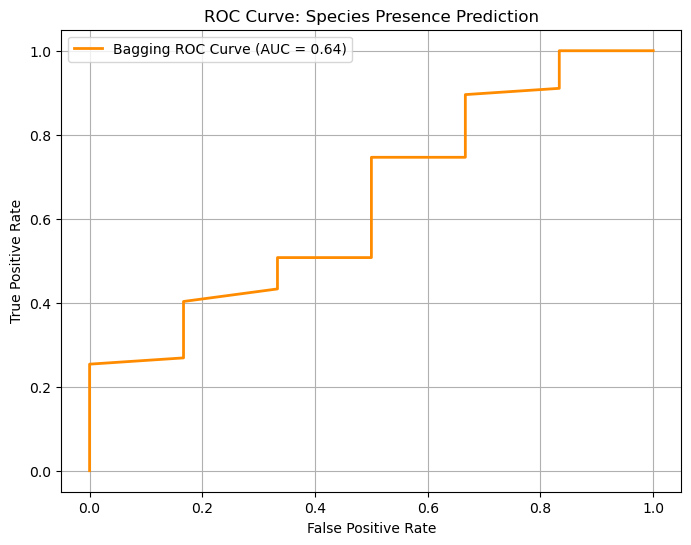

In [21]:
# Calculate the ROC curve 
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc_bagging = roc_auc_score(y_test, y_proba)

# Plot curves together
plt.figure(figsize=(8,6))

# Logistic curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Bagging ROC Curve (AUC = {roc_auc_bagging:.2f})')

plt.title('ROC Curve: Species Presence Prediction')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

Now how does the ROC curve look? How does this compare to our classification accuracy metric?  What might be going on? 

Our model have high accuracy but a low ROC-AUC score. This situation happens in imbalanced data sets where the model may only predict the majority class well but not distinguish between positive and negative classes.

### Step 6: Introducing upsampling

The ROC curve indicates that our model is not performing well.  This is a common issue in imbalanced datasets, where one class significantly outnumbers the other. To improve our model’s ability to correctly classify both groups, we will upsample the minority class so that both classes have equal representation in the training set.

**Perform upsampling to balance the dataset**
1. Separate the majority and minority classes:
- Identify which class (0,1) is underrepresented (the minority class) and which is overrepresented (the majority class). 
- Separate both the `X_train` data and `y_train` data into all majority class and all minority class sets. 
2. Apply upsampling:
- Use `resample()` to create additional synthetic samples of the minority class *with replacement* until it is the same size as the majority class data. Use a random state of 808. 
3. Combine the balanced classes:
Merge the original majority class with the newly upsampled minority class.
4. Shuffle the resampled dataset:
- Randomly shuffle the data to ensure the model does not learn any unintended patterns from the order of the data. Use a random state of 808 for shuffling both the resampled X and y training data. 
5. Print the value counts for the resampled y training data to ensure that the data is balanced. 


In [24]:
# Find class imbalance
bird_impute['Subarid'].value_counts()


Subarid
1    217
0     25
Name: count, dtype: int64

In [25]:
# Separate majority and minority classes
X_train_majority = X_train[y_train == 1]
X_train_minority = X_train[y_train == 0]
y_train_majority = y_train[y_train == 1]
y_train_minority = y_train[y_train == 0]

# Upsample the minority class
X_train_minority_up = resample(X_train_minority, 
                                random_state = 808,
                                n_samples=len(X_train_majority), 
                                replace=True)
                                             
y_train_minority_up = resample(y_train_minority, 
                                random_state = 808,
                                n_samples=len(X_train_majority), 
                                replace=True)
                                             
# Combine majority and upsampled minority classes
X_train_balanced = pd.concat([X_train_majority, X_train_minority_up])
y_train_balanced = pd.concat([y_train_majority, y_train_minority_up])

# Shuffle the dataset # initially used shuffle()but that messed up the model
X_train_balanced = resample(X_train_balanced, random_state=808)
y_train_balanced = resample(y_train_balanced, random_state=808)

# Print value counts 
print(f"Class distribution in balanced dataset:\n{y_train_balanced.value_counts()}")
 

Class distribution in balanced dataset:
Subarid
0    159
1    141
Name: count, dtype: int64


### Step 7: Retrain and evaluate model using balanced data

Now that we have addressed the class imbalance by upsampling the minority class, we will retrain the bagging classifier on the newly balanced dataset and evaluate its performance. This will help us determine whether handling class imbalance improves model accuracy and its ability to distinguish between classes. Create a bagging model using your balanced data. Use a random state of 808. Print the accuracy and and ROC Curve for this new model with balanced data. 

Bagging Out-of-Bag (OOB): 0.963;
Bagging Accuracy:  0.808


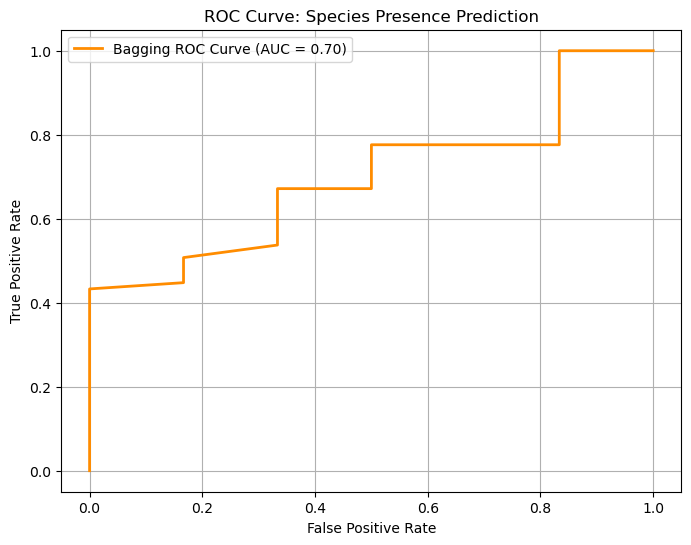

In [26]:
# initialize bagging classifier
bagging_2 = BaggingClassifier(
    #estimator = DecisionTreeClassifier(),
    n_estimators = 100, # Number of trees in bag
    oob_score = True,
    bootstrap = True,
    random_state = 808
)

# Train the model with balanced data
bagging_2.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_preds_2 = bagging_2.predict(X_test)
y_proba_2 = bagging_2.predict_proba(X_test)[:,1]

# Calculate bagging accuracy score
bagging_accuracy_2 = accuracy_score(y_test, y_preds_2)
oob_score_2 = bagging_2.oob_score_ 
# Print and compare
print(f"Bagging Out-of-Bag (OOB):{oob_score_2: .3f};\nBagging Accuracy: {bagging_accuracy_2: .3f}")

# Calculate ROC Curve
fpr_2, tpr_2, _ = roc_curve(y_test, y_proba_2)
# Get AUC
roc_auc_bagging_2 = roc_auc_score(y_test, y_proba_2)

# Plot ROC
plt.figure(figsize=(8,6))

# Logistic curve
plt.plot(fpr_2, tpr_2, color='darkorange', lw=2, label=f'Bagging ROC Curve (AUC = {roc_auc_bagging_2:.2f})')

plt.title('ROC Curve: Species Presence Prediction')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

How did this second model, trained on balanced data, do in comparison to the first on the accuracy and AUC metrics.  How should we interpret those results?  Did the upscaling prove useful?

The OOB scores increased from 0.858 to 0.963, indicating that the retrained model helped with model generalization. However, the accuracy of the model decreased from 0.932 to 0.808. The AUC increase (from 0.64 to 0.7) suggests that even though class imbalance is accounted for in the second model, there's no significant increase in performance with the upscaling.  

### Step 8: Analyzing feature importance with permutation importance

Understanding which bird traits contribute the most to our model’s predictions is crucial for interpreting results. We covered in lecture how the results of ensemble methods are harder to interpret than a single decision tree.  But we do have some tools to do it.  In this step, we will compute permutation importance, which measures the impact of each trait by shuffling its values and observing the effect on model performance. This will help us identify which functional traits—such as diet, body mass, or habitat breadth—play the biggest role in predicting whether a species is found in a subarid environment.

Use `permutation_importance()` to calculate the importance values.  You'll need to pass it the model, the feature and target test data, and an n_repeats value of 10.

In [27]:
# Calculate permutation importance
imp = permutation_importance(bagging_2, X_test, y_test, n_repeats = 10, random_state = 808)
imp
# List feature importance
imp_df = pd.DataFrame(zip(X_test.columns, imp.importances_mean), columns=['Feature', 'Importance'])

# Print the sorted feature importance
print(imp_df.sort_values(by = 'Importance', ascending = False))

               Feature    Importance
11     ForagingStratum  2.602740e-02
18        NestingHabit  2.465753e-02
0        AdultBodyMass  1.506849e-02
10       ActivityCycle  1.369863e-02
1          DietBreadth  5.479452e-03
3     Diet_Vertebrates  4.109589e-03
12     MigratoryStatus  4.109589e-03
19        MaxLongevity  2.739726e-03
15           EggLength  2.739726e-03
5         Diet_Flowers  1.110223e-17
6           Diet_seeds  0.000000e+00
7          Diet_Plants -1.369863e-03
8           Diet_Other -1.369863e-03
9         TrophicLevel -2.739726e-03
16            EggWidth -5.479452e-03
14          ClutchSize -6.849315e-03
4          Diet_Fruits -1.095890e-02
2   Diet_Invertebrates -1.369863e-02
17             EggMass -2.054795e-02
13      IncubationTime -2.191781e-02


What features are most important in our model of species distribution?

The top five most important features in our model are `ForagingStratum`, `NestingHabit`, `AdultBodyMass`, `ActivityCycle`, `DietBreadth`.